# Machine learning: Decision Tree

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
from pickle import dump
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

In [78]:
BASE_PATH = "../data/processed"
TRAIN_PATHS = [
    "X_train_con_outliers.xlsx",
    "X_train_sin_outliers.xlsx",
]
TRAIN_DATASETS = []
for path in TRAIN_PATHS:
    TRAIN_DATASETS.append(
        pd.read_excel(f"{BASE_PATH}/{path}")
    )

TEST_PATHS = [
    "X_test_con_outliers.xlsx",
    "X_test_sin_outliers.xlsx",
]
TEST_DATASETS = []
for path in TEST_PATHS:
    TEST_DATASETS.append(
        pd.read_excel(f"{BASE_PATH}/{path}")
    )

y_train = pd.read_excel(f"{BASE_PATH}/y_train.xlsx")
y_test = pd.read_excel(f"{BASE_PATH}/y_test.xlsx")

In [79]:
results = []
models=[]

for index, dataset in enumerate(TRAIN_DATASETS):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(dataset, y_train)
    models.append(model)
    
    y_pred_train = model.predict(dataset)
    y_pred_test = model.predict(TEST_DATASETS[index])

    results.append(
        {
            "train": accuracy_score(y_train, y_pred_train),
            "test": accuracy_score(y_test, y_pred_test)
        }
    )

results

[{'train': 1.0, 'test': 0.8376623376623377},
 {'train': 1.0, 'test': 0.8246753246753247}]

Hay overfitting en ambos resultados. Vamos a probar las predicciones con la selección de 5 características hecha

## Predicción con feature selection

In [80]:
train_data_con_outliers = pd.read_csv("../data/processed/clean_train_con_outliers.csv")
test_data_con_outliers = pd.read_csv("../data/processed/clean_test_con_outliers.csv")

X_train_con_outliers = train_data_con_outliers.drop(["Outcome"], axis = 1)
y_train_con_outliers = train_data_con_outliers["Outcome"]
X_test_con_outliers = test_data_con_outliers.drop(["Outcome"], axis = 1)
y_test_con_outliers = test_data_con_outliers["Outcome"]

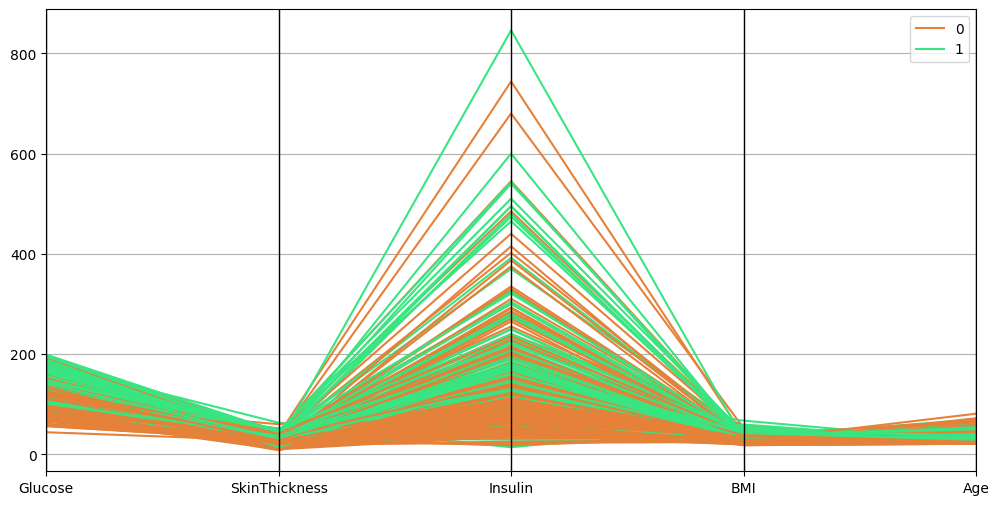

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

pd.plotting.parallel_coordinates(train_data_con_outliers, "Outcome", color = ("#E58139", "#39E581", "#8139E5"))

plt.show()

`SkinThickness` no parece determinante

In [82]:
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train_con_outliers, y_train_con_outliers)

DecisionTreeClassifier(random_state=42)

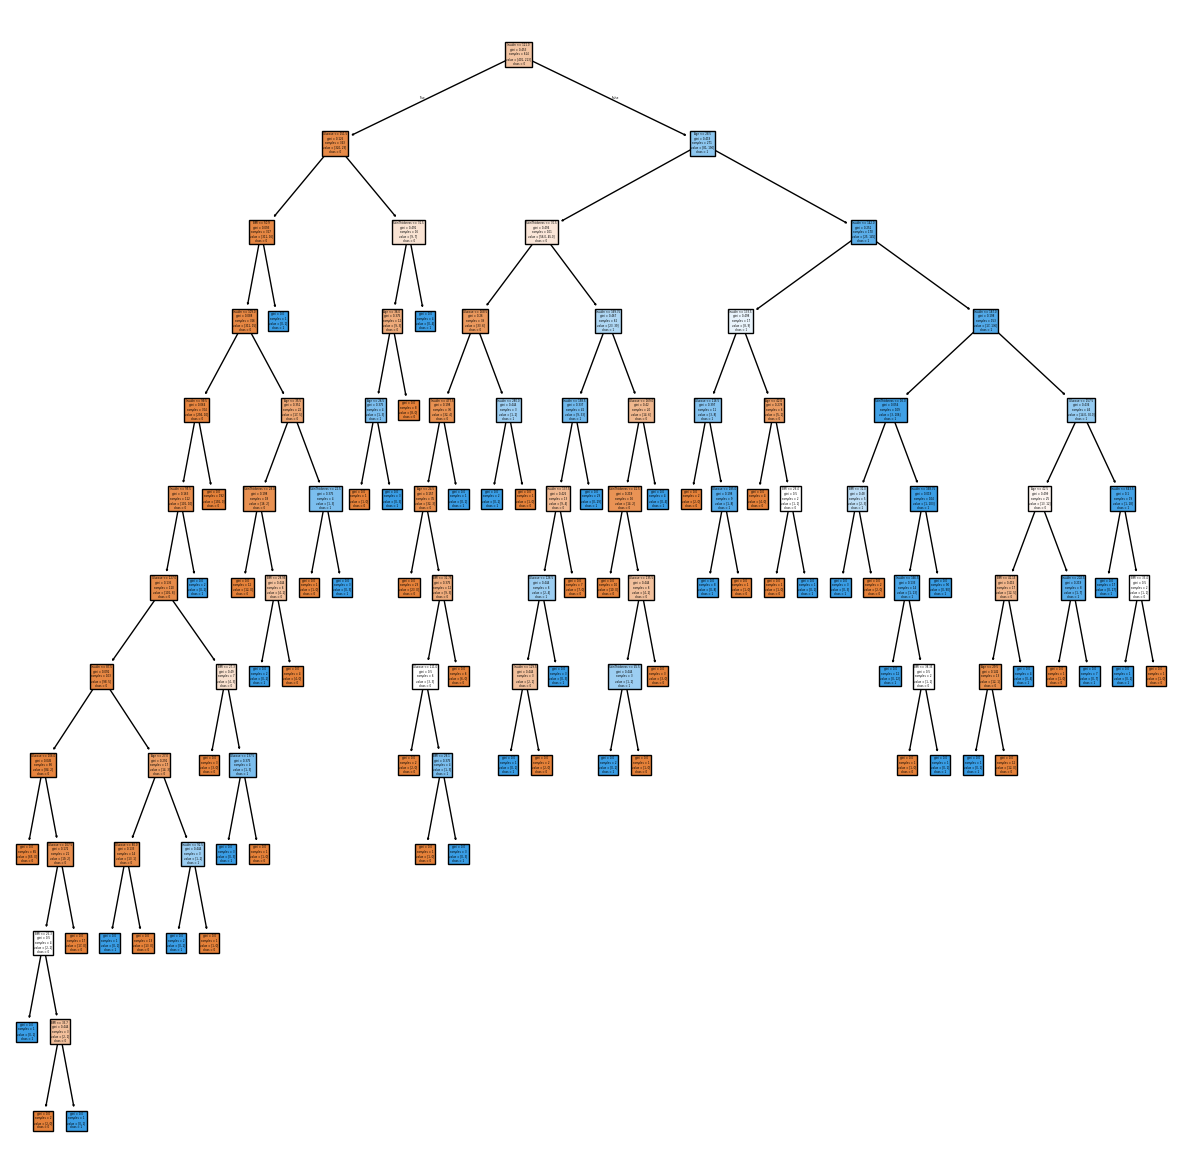

In [83]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(X_train_con_outliers.columns), class_names = ["0", "1"], filled = True)

plt.show()

In [84]:
y_pred_train = model.predict(X_train_con_outliers)
y_pred_test = model.predict(X_test_con_outliers)

print(f"Train: {accuracy_score(y_train_con_outliers, y_pred_train)}")
print(f"Test: {accuracy_score(y_test_con_outliers, y_pred_test)}")

Train: 1.0
Test: 0.8701298701298701


Sigue habiendo overfitting pero mejora el accuracy score de test

## Hiperparametrización

In [85]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(model, param_grid, scoring = "accuracy", cv = 5)
grid

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, 15],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [86]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

grid.fit(X_train_con_outliers, y_train_con_outliers)

print(f"Mejores hiperparámetros: {grid.best_params_}")

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [87]:
model = DecisionTreeClassifier(criterion = "entropy", max_depth = 5, min_samples_leaf = 4, min_samples_split = 2, random_state = 42)
model.fit(X_train_con_outliers, y_train_con_outliers)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       random_state=42)

In [88]:
y_pred_train = model.predict(X_train_con_outliers)
y_pred_test = model.predict(X_test_con_outliers)

print(f"Train: {accuracy_score(y_train_con_outliers, y_pred_train)}")
print(f"Test: {accuracy_score(y_test_con_outliers, y_pred_test)}")

Train: 0.9283387622149837
Test: 0.8636363636363636


In [89]:
results.append(
        {
            "train": accuracy_score(y_test_con_outliers, y_pred_test),
            "test": accuracy_score(y_train_con_outliers, y_pred_train),
            "best_params": grid.best_params_
        }
)

Reducido el accuracy score pero ya no hay tanta diferencia entre train y test

## Guardado del modelo

In [90]:
dump(model, open("../models/decision_tree_classifier_42.sav", "wb"))

## Guardado de los resultados

In [91]:
with open("../models/final_results.json", "w") as f:
    json.dump(results, f, indent=4)